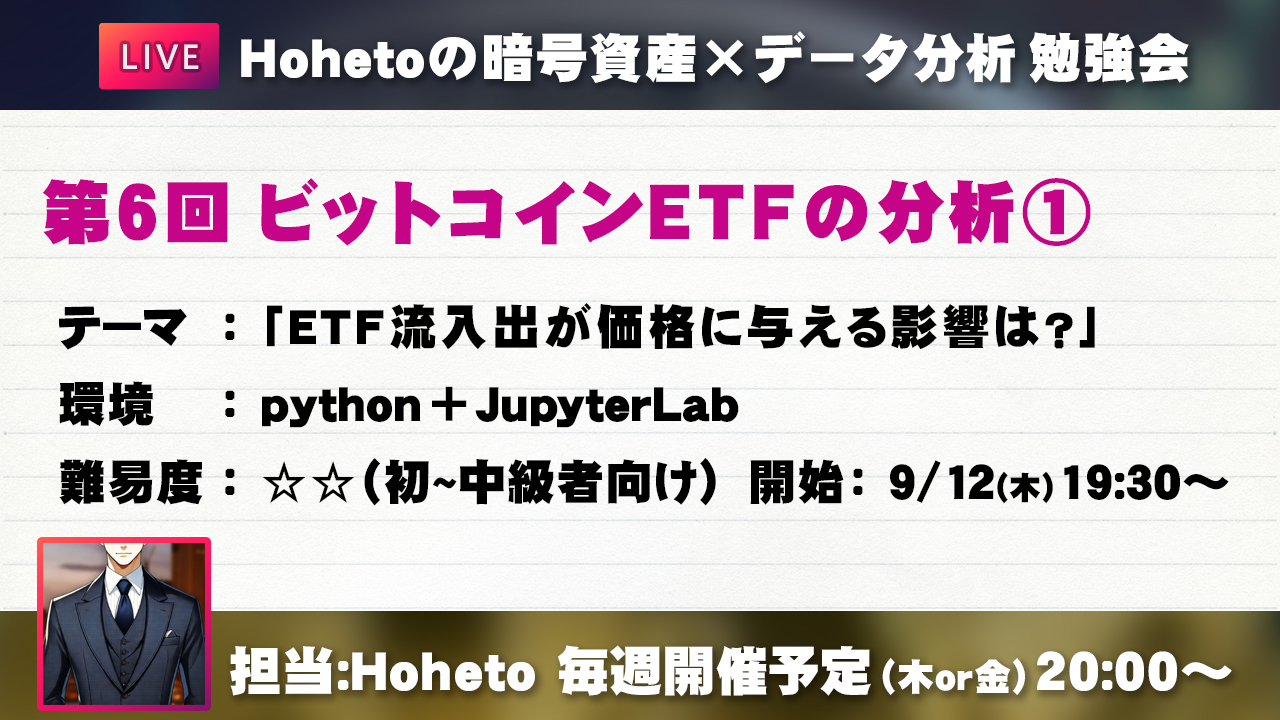

In [1]:
from IPython.display import Image

Image('./images/06_00.png')

# Hoheto勉強会 第6回 ビットコインETFの分析①

## 免責事項

- この勉強会では、過去のデータ分析を中心に行います。未来の値動きを断定したり投資に関するアドバイスを提供するものではありません。
- 投資は自己責任です。この内容に基づいて視聴者様が行う投資判断やその結果について、配信者は一切の責任を負いません。
- 内容には細心の注意を払っておりますが、正確性を完全に保証するものではありません。

## 概要

- ビットコインETFがローンチされて以降、ETFへの資金流入・流出と価格の相関が話題になっています。
- 実際のところ、どのような影響があるのかを分析します。
- 戦略への応用の可能性について、検討します。

## 前提知識

- Python。pandas、numpyなどのライブラリ。
- Jupyter。

## 内容・難易度

- 難易度☆☆2つ。

### 元ネタ

- 今回のネタは・・・
- [ https://twitter.com/sen_axis/status/1807357576897806651 ]

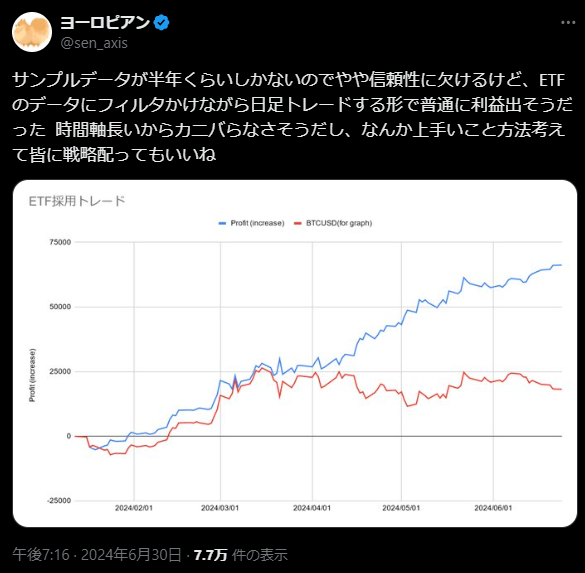

In [2]:
Image('./images/06_01.png')

# 今回の検証の流れ

- ビットコインの価格データを取得（Coinbase現物、Binance現物、Binance先物）します。
- ETF Net Flowデータを取得します。
- ETF Flowデータとビットコインの価格変動の関連を検証します。
- ETF Flowデータを利用した簡単な戦略を構築します。
- ETF Flowを先取りするための工夫を検討します。

# 環境設定

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
import ccxt
import japanize_matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import time
import warnings
from datetime import datetime
from tqdm import tqdm
from IPython.display import display, HTML, Image

In [5]:
# warning表示off
warnings.simplefilter('ignore')

# デフォルトフォントサイズ変更
plt.rcParams['font.size'] = 7

# デフォルトグラフサイズ変更
plt.rcParams['figure.figsize'] = (4, 4)

# データ取得

## ビットコイン価格データ取得

- 期間は2024/1/1～2024/9/9の253日間です。
- 使用データは、
  - Coinbaseビットコイン現物
  - Binanceビットコイン現物
  - Binance USDM ビットコイン無期限先物

In [6]:
from_ts = int(datetime(2024, 1, 1).timestamp() * 1000)
limit = 253

- Binance現物データを取得します。

In [7]:
binance = ccxt.binance()
ohlcv = binance.fetch_ohlcv(symbol='BTCUSDT', timeframe='1d', limit=limit, since=from_ts)
ohlcv = pd.DataFrame(ohlcv)
ohlcv.columns = ['ts', 'binance_open', 'binance_high', 'binance_low', 'binance_close', 'binance_volume']
ohlcv.index = pd.to_datetime(ohlcv['ts'] / 1000, unit='s', utc=True)

In [8]:
ohlcv

,ts,binance_open,binance_high,binance_low,binance_close,binance_volume
ts,,,,,,
2024-01-01 00:00:00+00:00,1704067200000,42283.58,44184.10,42180.77,44179.55,27174.29903
2024-01-02 00:00:00+00:00,1704153600000,44179.55,45879.63,44148.34,44946.91,65146.40661
2024-01-03 00:00:00+00:00,1704240000000,44946.91,45500.00,40750.00,42845.23,81194.55173
2024-01-04 00:00:00+00:00,1704326400000,42845.23,44729.58,42613.77,44151.10,48038.06334
2024-01-05 00:00:00+00:00,1704412800000,44151.10,44357.46,42450.00,44145.11,48075.25327
...,...,...,...,...,...,...
2024-09-05 00:00:00+00:00,1725494400000,57970.90,58327.07,55643.65,56180.00,27806.91413
2024-09-06 00:00:00+00:00,1725580800000,56180.00,57008.00,52550.00,53962.97,54447.76826
2024-09-07 00:00:00+00:00,1725667200000,53962.97,54850.00,53745.54,54160.86,16694.04774


- Binance Perpデータを取得します。

In [9]:
binanceusdm = ccxt.binanceusdm()
ohlcv_perp = binanceusdm.fetch_ohlcv(symbol='BTCUSDT', timeframe='1d', limit=limit, since=from_ts)
ohlcv_perp = pd.DataFrame(ohlcv_perp)
ohlcv_perp.columns = ['ts', 'binance_usdm_open', 'binance_usdm_high', 'binance_usdm_low', 'binance_usdm_close', 'binance_usdm_volume']
ohlcv_perp.index = pd.to_datetime(ohlcv_perp['ts'] / 1000, unit='s', utc=True)

In [10]:
ohlcv_perp

,ts,binance_usdm_open,binance_usdm_high,binance_usdm_low,binance_usdm_close,binance_usdm_volume
ts,,,,,,
2024-01-01 00:00:00+00:00,1704067200000,42314.0,44266.0,42207.9,44230.2,206424.144
2024-01-02 00:00:00+00:00,1704153600000,44230.3,45950.0,44200.9,44979.8,459798.523
2024-01-03 00:00:00+00:00,1704240000000,44979.7,45582.3,40333.0,42849.5,595855.225
2024-01-04 00:00:00+00:00,1704326400000,42849.5,44840.8,42625.0,44143.8,333923.098
2024-01-05 00:00:00+00:00,1704412800000,44143.8,44500.0,42300.0,44145.4,374967.791
...,...,...,...,...,...,...
2024-09-05 00:00:00+00:00,1725494400000,57944.8,58318.9,55600.0,56145.7,294703.592
2024-09-06 00:00:00+00:00,1725580800000,56145.7,57000.0,52510.8,53927.7,479063.113
2024-09-07 00:00:00+00:00,1725667200000,53927.7,54820.2,53725.0,54134.9,127686.594


- Coinbase現物データを取得します。

In [11]:
coinbase = ccxt.coinbase()
ohlcv_cb = coinbase.fetch_ohlcv(symbol='BTC/USD', timeframe='1d', limit=limit, since=from_ts)
ohlcv_cb = pd.DataFrame(ohlcv_cb)
ohlcv_cb.columns = ['ts', 'coinbase_open', 'coinbase_high', 'coinbase_low', 'coinbase_close', 'coinbase_volume']
ohlcv_cb.index = pd.to_datetime(ohlcv_cb['ts'] / 1000, unit='s', utc=True)

In [12]:
ohlcv_cb

,ts,coinbase_open,coinbase_high,coinbase_low,coinbase_close,coinbase_volume
ts,,,,,,
2024-01-01 00:00:00+00:00,1704067200000,42288.58,44240.80,42175.65,44220.78,7977.728511
2024-01-02 00:00:00+00:00,1704153600000,44220.78,45925.82,44195.13,44972.80,29583.384077
2024-01-03 00:00:00+00:00,1704240000000,44972.81,45519.32,40625.68,42862.44,32281.852344
2024-01-04 00:00:00+00:00,1704326400000,42860.58,44800.00,42650.00,44193.29,18193.816844
2024-01-05 00:00:00+00:00,1704412800000,44198.35,44443.37,42450.00,44186.59,18073.095615
...,...,...,...,...,...,...
2024-09-05 00:00:00+00:00,1725494400000,57971.00,58326.12,55628.04,56156.82,12281.578287
2024-09-06 00:00:00+00:00,1725580800000,56156.82,56995.00,52530.00,53950.01,18495.450644
2024-09-07 00:00:00+00:00,1725667200000,53950.00,54847.00,53733.10,54156.33,3284.577226


- 3種類の価格データを横方向に結合します。

In [13]:
ohlcv = pd.concat([ohlcv, ohlcv_perp, ohlcv_cb], axis=1)

In [14]:
ohlcv

,ts,binance_open,binance_high,binance_low,binance_close,binance_volume,ts,binance_usdm_open,binance_usdm_high,binance_usdm_low,binance_usdm_close,binance_usdm_volume,ts,coinbase_open,coinbase_high,coinbase_low,coinbase_close,coinbase_volume
ts,,,,,,,,,,,,,,,,,,
2024-01-01 00:00:00+00:00,1704067200000,42283.58,44184.10,42180.77,44179.55,27174.29903,1704067200000,42314.0,44266.0,42207.9,44230.2,206424.144,1704067200000,42288.58,44240.80,42175.65,44220.78,7977.728511
2024-01-02 00:00:00+00:00,1704153600000,44179.55,45879.63,44148.34,44946.91,65146.40661,1704153600000,44230.3,45950.0,44200.9,44979.8,459798.523,1704153600000,44220.78,45925.82,44195.13,44972.80,29583.384077
2024-01-03 00:00:00+00:00,1704240000000,44946.91,45500.00,40750.00,42845.23,81194.55173,1704240000000,44979.7,45582.3,40333.0,42849.5,595855.225,1704240000000,44972.81,45519.32,40625.68,42862.44,32281.852344
2024-01-04 00:00:00+00:00,1704326400000,42845.23,44729.58,42613.77,44151.10,48038.06334,1704326400000,42849.5,44840.8,42625.0,44143.8,333923.098,1704326400000,42860.58,44800.00,42650.00,44193.29,18193.816844
2024-01-05 00:00:00+00:00,1704412800000,44151.10,44357.46,42450.00,44145.11,48075.25327,1704412800000,44143.8,44500.0,42300.0,44145.4,374967.791,1704412800000,44198.35,44443.37,42450.00,44186.59,18073.095615
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-09-05 00:00:00+00:00,1725494400000,57970.90,58327.07,55643.65,56180.00,27806.91413,1725494400000,57944.8,58318.9,55600.0,56145.7,294703.592,1725494400000,57971.00,58326.12,55628.04,56156.82,12281.578287
2024-09-06 00:00:00+00:00,1725580800000,56180.00,57008.00,52550.00,53962.97,54447.76826,1725580800000,56145.7,57000.0,52510.8,53927.7,479063.113,1725580800000,56156.82,56995.00,52530.00,53950.01,18495.450644
2024-09-07 00:00:00+00:00,1725667200000,53962.97,54850.00,53745.54,54160.86,16694.04774,1725667200000,53927.7,54820.2,53725.0,54134.9,127686.594,1725667200000,53950.00,54847.00,53733.10,54156.33,3284.577226


- 価格リターン（3種類）とcoinbase/binance乖離、binance先物乖離を計算します。

In [15]:
ohlcv['binance_ror'] = (ohlcv['binance_close'] - ohlcv['binance_open']) / ohlcv['binance_open']
ohlcv['binance_usdm_ror'] = (ohlcv['binance_usdm_close'] - ohlcv['binance_usdm_open']) / ohlcv['binance_usdm_open']
ohlcv['coinbase_ror'] = (ohlcv['coinbase_close'] - ohlcv['coinbase_open']) / ohlcv['coinbase_open']
ohlcv['coinbase_binance_dev'] = (ohlcv['coinbase_close'] / ohlcv['binance_close']) - 1
ohlcv['binance_perp_dev'] = (ohlcv['binance_usdm_close'] / ohlcv['binance_close']) - 1

- 価格推移を確認します。

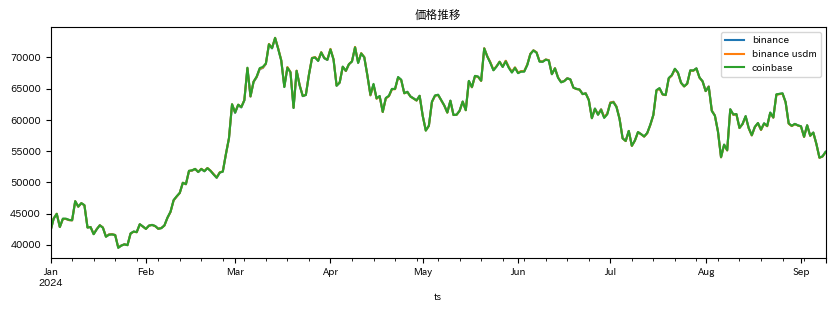

In [16]:
plt.figure(figsize=(10, 3))
plt.title('価格推移')
ohlcv['binance_open'].plot(label='binance')
ohlcv['binance_usdm_open'].plot(label='binance usdm')
ohlcv['coinbase_open'].plot(label='coinbase')
plt.legend();

- 乖離推移を確認します。

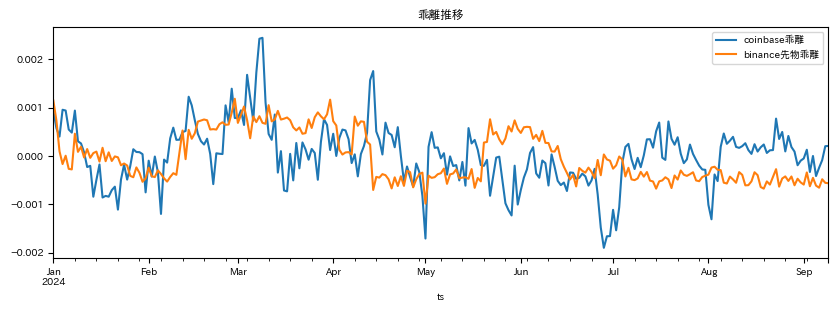

In [17]:
plt.figure(figsize=(10, 3))
plt.title('乖離推移')
ohlcv['coinbase_binance_dev'].plot(label='coinbase乖離')
ohlcv['binance_perp_dev'].plot(label='binance先物乖離')
plt.legend();

- 価格リターンの分布を確認します。

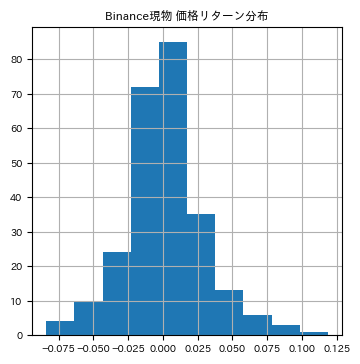

In [18]:
plt.title('Binance現物 価格リターン分布')
ohlcv['binance_ror'].hist();

## ETF Net Flowデータ取得

- Coinglass APIより（有料、APIキーが必要）取得します。
- いくつか表形式で表示しているサイトがあるので、スクレイピングするなりして無料で収集することも可能です。

In [ ]:
import requests

url = "https://open-api-v3.coinglass.com/api/bitcoin/etf/flow-history"
headers = {
    "accept": "application/json",
    "CG-API-KEY": "MY-API-KEY"
}
etf_flow = requests.get(url, headers=headers).json()

In [23]:
etf_flow['data'][0]

{'date': 1704931200000,
 'changeUsd': 655300000.0,
 'price': 46663,
 'closePrice': 46337.8,
 'list': [{'ticker': 'IBIT', 'changeUsd': 111700000.0},
  {'ticker': 'FBTC', 'changeUsd': 227000000.0},
  {'ticker': 'BITB', 'changeUsd': 237900000.0},
  {'ticker': 'ARKB', 'changeUsd': 65300000.0},
  {'ticker': 'BTCO', 'changeUsd': 17400000.0},
  {'ticker': 'EZBC', 'changeUsd': 50100000.0},
  {'ticker': 'BRRR', 'changeUsd': 29400000.0},
  {'ticker': 'HODL', 'changeUsd': 10600000.0},
  {'ticker': 'BTCW', 'changeUsd': 1000000.0},
  {'ticker': 'GBTC', 'changeUsd': -95100000.0},
  {'ticker': 'BTC'}]}

In [24]:
etf_flow_data = []
for flow in etf_flow['data']:
    record = {}
    record['ts'] = flow['date'] / 1000
    record['total'] = flow['changeUsd']
    for etf_symbol in flow['list']:
        record[f'{etf_symbol["ticker"].lower()}'] = etf_symbol['changeUsd'] if 'changeUsd' in etf_symbol else None
    etf_flow_data.append(record)

etf_flow_data = pd.DataFrame(etf_flow_data)
etf_flow_data['ts'] = pd.to_datetime(etf_flow_data['ts'], unit='s', utc=True)
etf_flow_data = etf_flow_data.set_index('ts')

In [25]:
etf_flow_data

,total,ibit,fbtc,bitb,arkb,btco,ezbc,brrr,hodl,btcw,gbtc,btc
ts,,,,,,,,,,,,
2024-01-11 00:00:00+00:00,655300000.0,111700000.0,227000000.0,237900000.0,65300000.0,17400000.0,50100000.0,29400000.0,10600000.0,1000000.0,-95100000.0,NaN
2024-01-12 00:00:00+00:00,203000000.0,386000000.0,195300000.0,17400000.0,39800000.0,28400000.0,0.0,20200000.0,0.0,0.0,-484100000.0,NaN
2024-01-15 00:00:00+00:00,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2024-01-16 00:00:00+00:00,-52700000.0,212700000.0,102000000.0,50200000.0,122300000.0,31900000.0,0.0,15300000.0,7300000.0,0.0,-594400000.0,NaN
2024-01-17 00:00:00+00:00,453800000.0,371400000.0,358100000.0,68200000.0,50300000.0,57600000.0,1200000.0,1200000.0,4800000.0,1600000.0,-460600000.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
2024-09-06 00:00:00+00:00,-170000000.0,0.0,-85500000.0,-14300000.0,-7200000.0,0.0,0.0,-4600000.0,0.0,0.0,-52900000.0,-5500000.0
2024-09-09 00:00:00+00:00,28600000.0,-9100000.0,28600000.0,22000000.0,6800000.0,3100000.0,0.0,0.0,0.0,0.0,-22800000.0,0.0
2024-09-10 00:00:00+00:00,117000000.0,0.0,63200000.0,0.0,12700000.0,0.0,0.0,0.0,0.0,0.0,0.0,41100000.0


- Nan値をゼロ埋めします。

In [26]:
etf_flow_data = etf_flow_data.fillna(0)

- totalのNet Flowが、他全てのetfのNet Flowの合計になっていることを確認します。

In [27]:
etf_flow_data.drop(['total'], axis=1).sum(axis=1)

ts
2024-01-11 00:00:00+00:00    655300000.0
2024-01-12 00:00:00+00:00    203000000.0
2024-01-15 00:00:00+00:00            0.0
2024-01-16 00:00:00+00:00    -52700000.0
2024-01-17 00:00:00+00:00    453800000.0
                                ...     
2024-09-06 00:00:00+00:00   -170000000.0
2024-09-09 00:00:00+00:00     28600000.0
2024-09-10 00:00:00+00:00    117000000.0
2024-09-11 00:00:00+00:00    -43900000.0
2024-09-12 00:00:00+00:00     39000000.0
Length: 176, dtype: float64

In [28]:
(etf_flow_data.drop(['total'], axis=1).sum(axis=1) != etf_flow_data['total']).sum()

0

- 各ETFのNet Flowの合計を確認します。
  - 支配的なのは、iBIT（BlackRock）、GBTC（Grayscale）、FBTC（Fidelity）です。
  - GBTCは2020年にローンチされたGrayscaleのビットコイン信託だが、信託報酬が高額。手数料が安く流動性が高いETFがローンチされたため流出が続いています。

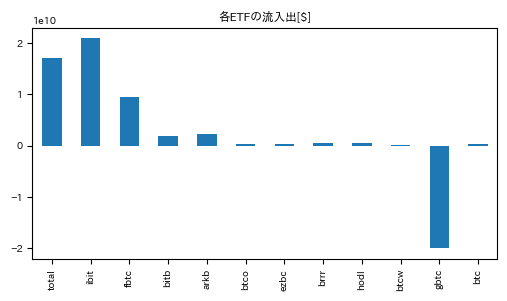

In [29]:
plt.figure(figsize=(6, 3))
plt.title('各ETFの流入出[$]')
etf_flow_data.sum().plot(kind='bar');

- GBTC、IBIT、FBTCのNet Flowの累積を確認します。

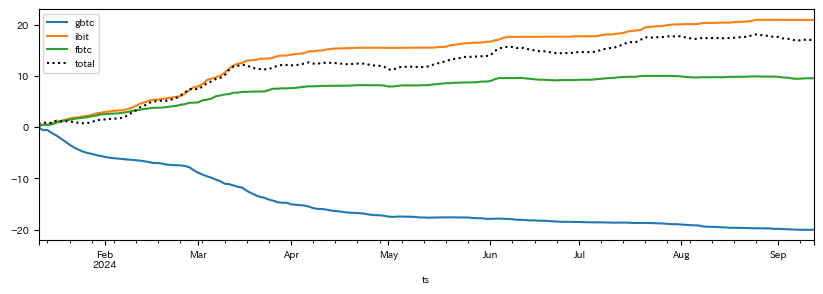

In [30]:
plt.figure(figsize=(10, 3))
(etf_flow_data['gbtc'] / 1e9).cumsum().plot()
(etf_flow_data['ibit'] / 1e9).cumsum().plot()
(etf_flow_data['fbtc'] / 1e9).cumsum().plot()
(etf_flow_data['total'] / 1e9).cumsum().plot(style='k:')
plt.legend();

- OHLCVのデータと結合します。

In [31]:
ohlcv = pd.concat([ohlcv, etf_flow_data], axis=1)

- ETFデータを取得できている1/11以降のデータのみ使用します。

In [32]:
ohlcv = ohlcv['2024-01-11':]

In [33]:
ohlcv

,ts,binance_open,binance_high,binance_low,binance_close,binance_volume,ts,binance_usdm_open,binance_usdm_high,binance_usdm_low,...,fbtc,bitb,arkb,btco,ezbc,brrr,hodl,btcw,gbtc,btc
ts,,,,,,,,,,,,,,,,,,,,,
2024-01-11 00:00:00+00:00,1.704931e+12,46654.00,48969.48,45606.06,46339.16,87470.32960,1.704931e+12,46663.0,49027.5,45600.0,...,227000000.0,237900000.0,65300000.0,17400000.0,50100000.0,29400000.0,10600000.0,1000000.0,-95100000.0,0.0
2024-01-12 00:00:00+00:00,1.705018e+12,46339.16,46515.53,41500.00,42782.73,86327.93707,1.705018e+12,46337.9,46536.2,41370.0,...,195300000.0,17400000.0,39800000.0,28400000.0,0.0,20200000.0,0.0,0.0,-484100000.0,0.0
2024-01-13 00:00:00+00:00,1.705104e+12,42782.74,43257.00,42436.12,42847.99,36118.47464,1.705104e+12,42789.0,43273.4,42445.7,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2024-01-14 00:00:00+00:00,1.705190e+12,42847.99,43079.00,41720.00,41732.35,28228.40894,1.705190e+12,42846.4,43096.1,41713.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2024-01-15 00:00:00+00:00,1.705277e+12,41732.35,43400.43,41718.05,42511.10,40269.89303,1.705277e+12,41734.9,43376.0,41720.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-09-08 00:00:00+00:00,1.725754e+12,54160.86,55318.00,53629.01,54869.95,16274.14779,1.725754e+12,54134.9,55300.0,53596.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2024-09-09 00:00:00+00:00,1.725840e+12,54869.95,58088.00,54591.96,57042.00,32384.51737,1.725840e+12,54839.6,58153.2,54557.0,...,28600000.0,22000000.0,6800000.0,3100000.0,0.0,0.0,0.0,0.0,-22800000.0,0.0
2024-09-10 00:00:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,63200000.0,0.0,12700000.0,0.0,0.0,0.0,0.0,0.0,0.0,41100000.0


- Net Flowは土日がNan値になっていますが、いったんこの状態にしておきます。

## プロット

- ビットコイン価格とNet Flowの累積をプロットします。

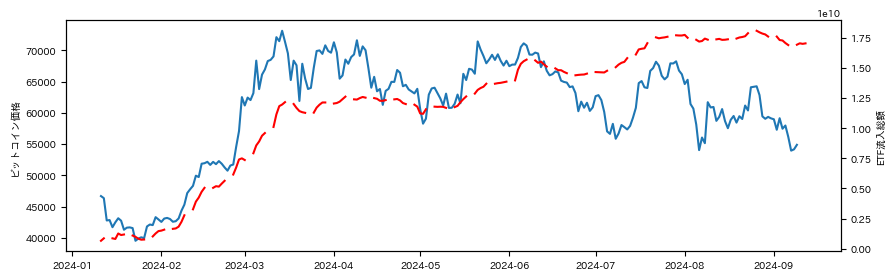

In [34]:
plt.figure(figsize=(10, 3))
ax = plt.gca()
ax.plot(ohlcv['coinbase_open'])
ax.set_ylabel('ビットコイン価格')
ax_right = ax.twinx()
ax_right.plot(ohlcv['total'].cumsum(), color='red')
ax_right.set_ylabel('ETF流入総額');

# ETF Net Flowと価格変化の関係

## ETF経由の流入出とは何なのか

In [35]:
etf_flow_data.tail(20)

,total,ibit,fbtc,bitb,arkb,btco,ezbc,brrr,hodl,btcw,gbtc,btc
ts,,,,,,,,,,,,
2024-08-16 00:00:00+00:00,35900000.0,20400000.0,61300000.0,12000000.0,13400000.0,0.0,1700000.0,0.0,0.0,0.0,-72900000.0,0.0
2024-08-19 00:00:00+00:00,62100000.0,92700000.0,3900000.0,-25700000.0,0.0,-8800000.0,0.0,0.0,0.0,0.0,0.0,0.0
2024-08-20 00:00:00+00:00,88000000.0,55400000.0,0.0,-6500000.0,51900000.0,0.0,0.0,0.0,0.0,0.0,-12800000.0,0.0
2024-08-21 00:00:00+00:00,39500000.0,8400000.0,10700000.0,10000000.0,0.0,2500000.0,3500000.0,0.0,0.0,0.0,-9800000.0,14200000.0
2024-08-22 00:00:00+00:00,64800000.0,75500000.0,9200000.0,-11500000.0,7800000.0,0.0,0.0,0.0,3400000.0,4800000.0,-28400000.0,4000000.0
2024-08-23 00:00:00+00:00,252000000.0,86800000.0,64000000.0,42300000.0,23800000.0,3200000.0,0.0,2300000.0,14400000.0,0.0,-35600000.0,50800000.0
2024-08-26 00:00:00+00:00,200400000.0,221900000.0,-8300000.0,-16600000.0,0.0,0.0,5500000.0,0.0,-7200000.0,5100000.0,0.0,0.0
2024-08-27 00:00:00+00:00,-127100000.0,0.0,0.0,-6800000.0,-102000000.0,0.0,0.0,0.0,0.0,0.0,-18300000.0,0.0
2024-08-28 00:00:00+00:00,-105300000.0,0.0,-10400000.0,-8700000.0,-59300000.0,0.0,0.0,0.0,-10100000.0,0.0,-8000000.0,-8800000.0


- 各ETFには以下が設定されている。
  - Nav・・・Net Asset Value。そのFundが保有するアセットの評価額
  - shares・・・発行済の口数。
  - 基準価額・・・Nav を 発行済み口数で割ったもの。
- 例えば、10 BTCを保有するファンドがある。BTC価格は現在10000ドル。口数は1000口。とすると、Navは10万ドル、基準価額は100ドルとなる。
- BTCが11000ドルに上がったら、Navは11万ドル、基準価額は110ドルに上がる。
- Nasdaqで取引されているETFは、発行済のもの。基準価額が110ドルなのに105ドルで売られていれば、当然買われて基準価額に近づく。
- ただし、これは買いたい人と売りたい人のマッチング。ここで売買されても、資金が流入 or 流出しているとは言わない。
- では流入出とは？

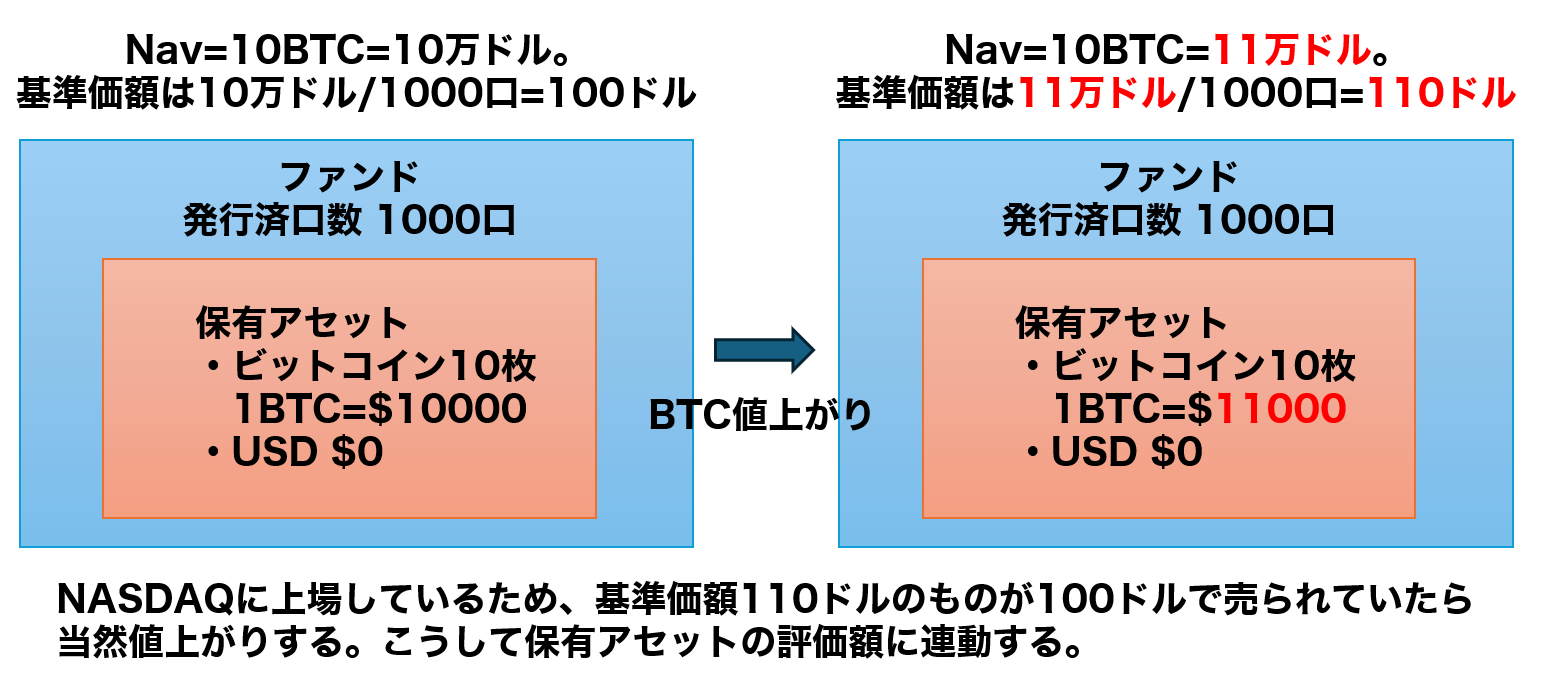

In [36]:
Image('./images/06_02.png', width=1000)

- ETFを購入したい人が売却したい人を上回れば、価格にプレミアムが乗る。
- 例えば、基準価額100ドルのETFが市場で買われ、110ドル（+10%）まで上がったとする。この状態だと、ファンドの評価額が11万ドルに対し、裏付けとなる資産が 10BTC（10万ドル）となる。
- ファンドはこの10%のプレミアムに対して、ETFを新規で発行する（creation）。
  - 発行済口数の10%である、100口を新たに発行するとする。
  - 発行は基準価額をベースに行われる（このため、Fundの持つ資産価値に影響は与えられない）。100口×100ドル=10000ドル。
  - 認可参加者が、10000ドル分のビットコイン（=1BTC）を調達する。
  - 認可参加者が、調達したビットコインをファンドに提供し、100口を引き受ける。
  - 認可参加者が、100口を市場で売却し（110ドル）、プレミアム分の収益を得る。
  - 需給が調整され、ETFの市場価格が基準価格100ドルに戻る。
- すると、
  - 11 BTC（1BTC=10000ドル）、Nav=11万ドル、口数1100口、基準価額100ドル、となる。
  - こうして、ETFの基準価額は保有アセットの評価額に連動し、資金が集まればファンドの規模（Nav）が大きくなっていく。

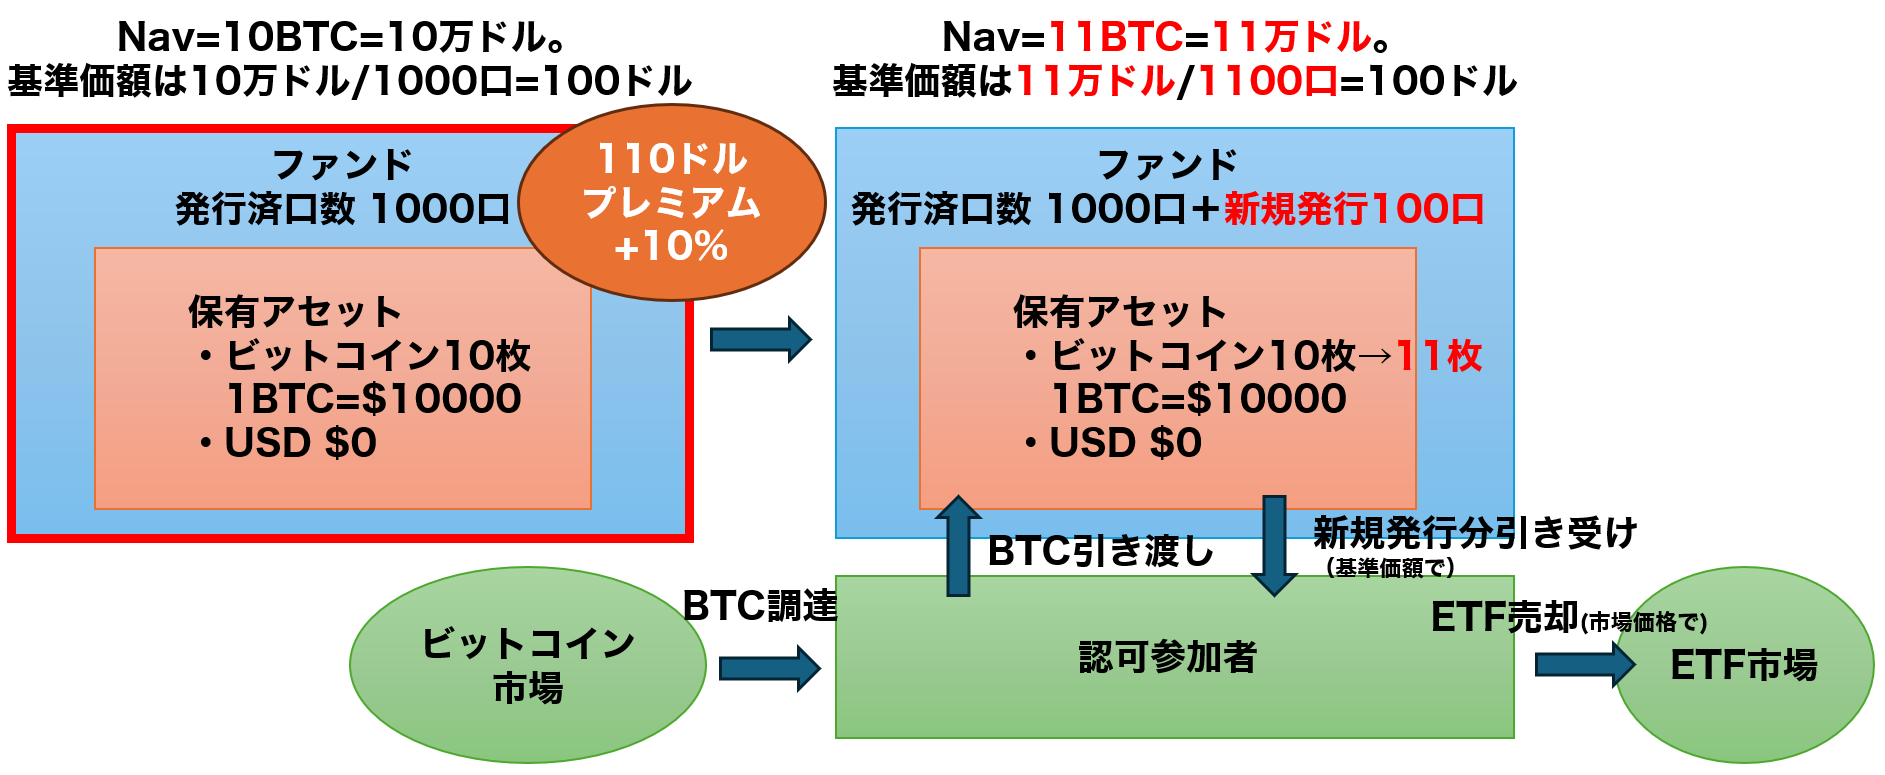

In [37]:
Image('./images/06_03.png', width=1000)

- ETFを売却したい人が購入したい人を上回れば、価格がディスカウントされる。
- 例えば、基準価額100ドルのETFが市場で売られ、90ドル（-10%）まで下がったとする。この状態だと、ファンドの評価額が9万ドルに対し、裏付けとなる資産が 10BTC（10万ドル）となる。
- ファンドはこの10%のディスカウントに対して、ETFを償還する（redemption）。
  - 発行済口数の10%である100口を償還するとする。
  - 認可参加者がETF100口を市場で購入する。
  - 認可参加者が購入したETFをファンドに持ち込み、償還を依頼する。
  - ファンドは、ETFの基準価格をベースにして、ビットコインを渡す。100口×100ドル=10000ドル=1BTC。
  - 認可参加者は10000ドル分のビットコインを売却し、ディスカウント分の収益を得る。
  - 需給が調整され、ETFの市場価格が基準価格100ドルに戻る。
- すると
  - 9 BTC（1BTC=10000ドル）、Nav=9万ドル、口数900口、基準価額100ドル、となる。
  - こうして、ETFの基準価額は保有アセットの評価額に連動し、資金が流出すればファンドの規模（Nav）が小さくなっていく。

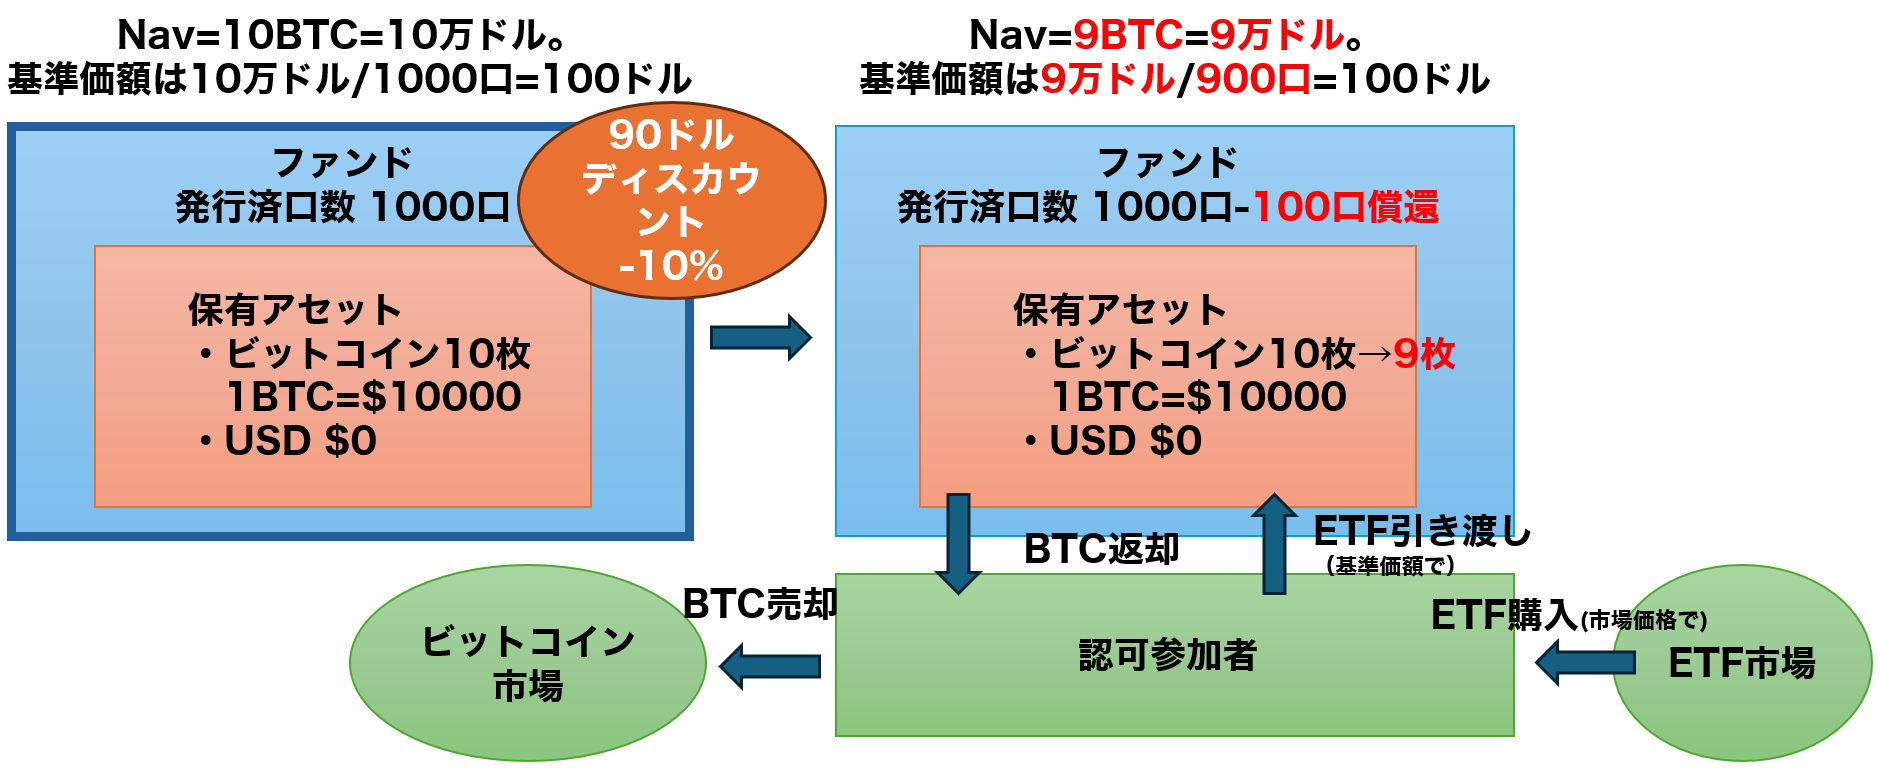

In [38]:
Image('./images/06_04.png', width=1000)

- じゃあ、ETF Net Flowとは何なのか？
  - 新たに作成されたETF（流入）と償還されたETF（流出）の差を表している。
  - 認可参加者がいつビットコインを調達、あるいは売却しているかは分からない。
  - しかし、実需を表しており、どこかのタイミングではビットコインの売買が行われている。

- どのタイミングでNet Flowが発生するかはETFによってまちまちである
- 大型のETFのほうが頻度が多い傾向にある。

## 当日のETF Net Flowと価格変化の相関

- 横軸: 各日付のETF Net Flow
- 縦軸: その日のビットコインの日次リターン（つまり価格変化のパーセンテージ）
- 正の相関が観測されます。相関係数は0.3771。

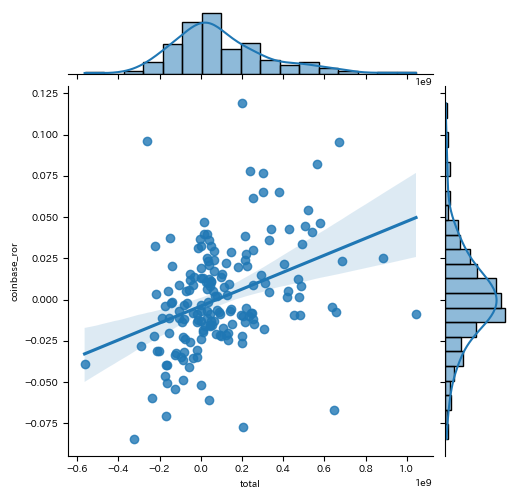

In [39]:
sns.jointplot(data=ohlcv, x='total', y='coinbase_ror', kind='reg', height=5);

## 回帰分析

- Net Flowの単位を$1Bに変更して、線形回帰を試します。

In [40]:
import statsmodels.api as sm

ohlcv_tmp = ohlcv[['total', 'coinbase_ror']].copy()
ohlcv_tmp = ohlcv_tmp.dropna()
ohlcv_tmp['total'] = ohlcv_tmp['total'] / 1e9  # 1Bあたりに直す
X = sm.add_constant(ohlcv_tmp['total'])
y = ohlcv_tmp['coinbase_ror']

# OLSは最小二乗法.
model = sm.OLS(y, X)
results = model.fit()
summary = results.summary()

- 線形回帰の結果を表示します。
  - 決定係数は0.1422です。これは、ビットコイン価格変化のうち、14%がETF Net Flowによって説明できることを示しています。
  - p値が十分小さいことから、ETF Net Flowが価格に対して有意に影響を与えていることが分かります。
  - 回帰直線の傾きは0.0513です。つまり$1Bの流入当たり5.13%の価格上昇効果が確認できます。

In [41]:
print(summary)

                            OLS Regression Results                            
Dep. Variable:           coinbase_ror   R-squared:                       0.142
Model:                            OLS   Adj. R-squared:                  0.137
Method:                 Least Squares   F-statistic:                     28.36
Date:                Fri, 13 Sep 2024   Prob (F-statistic):           3.14e-07
Time:                        00:57:45   Log-Likelihood:                 361.74
No. Observations:                 173   AIC:                            -719.5
Df Residuals:                     171   BIC:                            -713.2
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0039      0.002     -1.584      0.1

## 米国時間の中での相関

- ETFの作成や償還は、通常は市場の取引時間内に行われるのでは？
- 米国時間9:30～16時の間の価格変化と相関を取ってみます。

- ビットコインの30分足を取って、米国時間のみを抜き出してリターンを計測します。

In [42]:
from dateutil import parser

def fetch_binance_spot_candles(symbol, from_date, to_date):
    from_time = int(parser.parse(from_date).timestamp() * 1000)
    to_time = int(parser.parse(to_date).timestamp() * 1000)
    interval = '30m'
    resolution = 60 * 30
    limit = 1000
    endpoint = 'https://api.binance.com/api/v3/klines'
    start_time = from_time
    kline_list = []
    while True:
        end_time = start_time + resolution * 1000 * limit - 1
        if end_time > to_time:
            end_time = to_time
        params={'symbol': symbol, 'startTime': start_time, 'endTime': end_time, 'interval': interval, 'limit': limit}
        kline = requests.get(endpoint, params).json()
        kline = pd.DataFrame(kline).astype(float)
        kline.columns = ['open_time', 'open_price', 'high_price', 'low_price', 'close_price', 'volume', 'close_time', 'quote_volume', 'trade_num', 'buy_volume', 'quote_buy_volume', 'ignore1']
        kline.index = pd.to_datetime(kline['open_time'] / 1000, unit='s', utc=True)
        kline_list.append(kline)
        if end_time == to_time:
            break
        start_time = end_time + 1
    return pd.concat(kline_list, axis=0).sort_index()

In [43]:
ohlcv_30m_org = fetch_binance_spot_candles('BTCUSDT', '2024-01-01', '2024-09-10')

In [44]:
ohlcv_us = ohlcv_30m_org.copy()
ohlcv_us.index = ohlcv_us.index.tz_convert('America/New_York')
ohlcv_us = ohlcv_us.iloc[ohlcv_us.index.indexer_between_time('09:30', '16:00')]
ohlcv_us.index = ohlcv_us.index.tz_convert('UTC')
ohlcv_us = ohlcv_us.resample('1d').agg({'open_price': 'first', 'high_price': 'max', 'low_price': 'min', 'close_price': 'last', 'volume': 'sum'})
ohlcv_us['binance_ror_us'] = (ohlcv_us['close_price'] - ohlcv_us['open_price']) / ohlcv_us['open_price']
ohlcv['binance_ror_us'] = ohlcv_us['binance_ror_us']

- 横軸: 各日付のETF Net Flow
- 縦軸: その日の米国時間のリターン
- 結果
  - ダメ。相関は0.1412まで減少。
  - ETFが新たに作成されるような相場では、時間帯によらず価格変動が起こりやすいのかもしれない。
  - あるいは、ビットコイン市場は24時間なので時間帯は関係ないのかもしれない。

In [45]:
ohlcv['total'].corr(ohlcv['binance_ror_us'])

0.14121388252684874

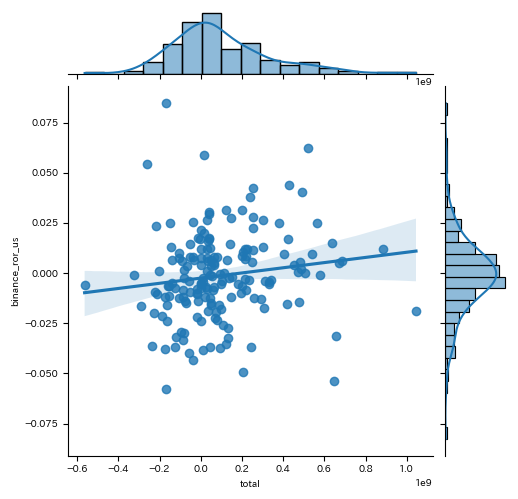

In [46]:
sns.jointplot(data=ohlcv, x='total', y='binance_ror_us', kind='reg', height=5);

## ETF Net Flowと価格変化のラグ相関

- ①ETF Net Flowの自己相関を確認します。
  - 強めに正の相関を観測できます。
  - これは、ETFが流入すると、翌日以降流入する傾向（正のフィードバック）を示しています。

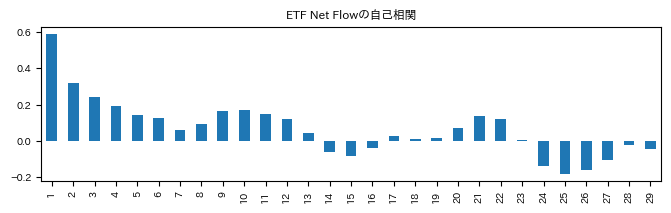

In [47]:
corr = {}
ohlcv_tmp = ohlcv.dropna().copy()
for i in range(1, 30):
    corr[i] = ohlcv_tmp['total'].shift(i).corr(ohlcv_tmp['total'])
plt.figure(figsize=(8, 2))
pd.Series(corr).plot(kind='bar')
plt.title('ETF Net Flowの自己相関');

- ②日次価格変化の自己相関を確認します。
  - 直前の価格変化と負の相関があります（前日から反発する）。※4回目の勉強会「価格系列の自己相関」で登場

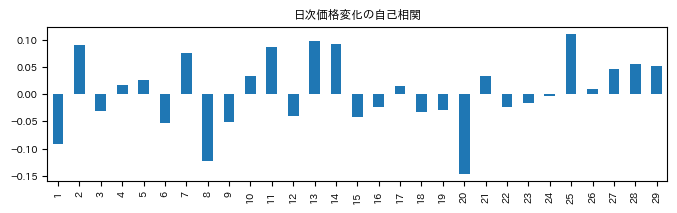

In [48]:
corr = {}
for i in range(1, 30):
    corr[i] = ohlcv['coinbase_ror'].shift(i).corr(ohlcv['coinbase_ror'])
plt.figure(figsize=(8, 2))
pd.Series(corr).plot(kind='bar')
plt.title('日次価格変化の自己相関');

- ③ETF Net Flow ラグi -> 当日価格変化の相関を確認します。
  - ラグ1の相関が意外と小さいことが確認できます。
  - ETF Net Flowは、ラグ1だと上記のような価格の自己相関と相殺され、翌日の価格変化とはさほど相関しないようです。

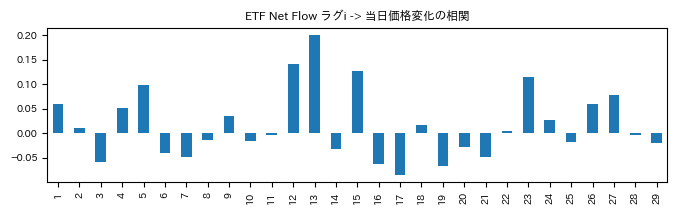

In [49]:
corr = {}
for i in range(1, 30):
    ohlcv_tmp = ohlcv.copy()
    ohlcv_tmp['total_s'] = ohlcv_tmp['total'].shift(i)
    ohlcv_tmp = ohlcv_tmp[['total_s', 'coinbase_ror']].dropna()
    corr[i] = ohlcv_tmp['total_s'].corr(ohlcv_tmp['coinbase_ror'])
plt.figure(figsize=(8, 2))
pd.Series(corr).plot(kind='bar')
plt.title('ETF Net Flow ラグi -> 当日価格変化の相関');

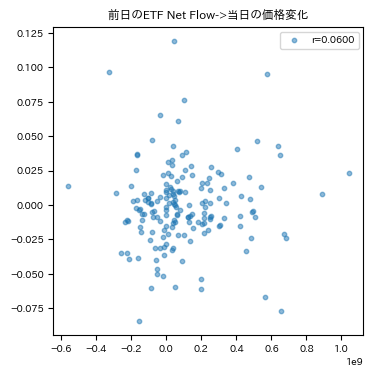

In [50]:
ohlcv_tmp = ohlcv.copy()
ohlcv_tmp['total_s1'] = ohlcv_tmp['total'].shift(1)
plt.title('前日のETF Net Flow->当日の価格変化')
plt.scatter(ohlcv_tmp['total_s1'], ohlcv_tmp['coinbase_ror'], alpha=0.5, s=10, label=f'r={ohlcv_tmp["total_s1"].corr(ohlcv_tmp["coinbase_ror"]):.4f}')
plt.legend();

- ④日次価格変化 ラグi -> 当日ETF Net Flowの相関を確認します。
  - 正の相関が認められます。10日後程度まで価格変化の影響が残っています。
  - つまり、ETF Net Flowが価格変化を起こすというより、価格変化がETF Net Flow引き起こす、と言えそうです。

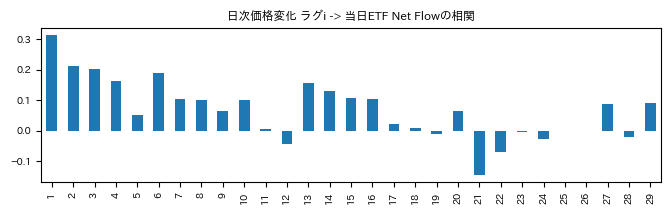

In [51]:
corr = {}
for i in range(1, 30):
    ohlcv_tmp = ohlcv.copy()
    ohlcv_tmp['coinbase_ror_s'] = ohlcv_tmp['coinbase_ror'].shift(i)
    ohlcv_tmp = ohlcv_tmp[['coinbase_ror_s', 'total']].dropna()
    corr[i] = ohlcv_tmp['coinbase_ror_s'].corr(ohlcv_tmp['total'])
plt.figure(figsize=(8, 2))
pd.Series(corr).plot(kind='bar')
plt.title('日次価格変化 ラグi -> 当日ETF Net Flowの相関');

- まず、「当日の流入」と「当日の価格変化」については強い相関があるのは間違いないなさそうです。
- ただし、前日の流入量が当日価格に与える影響は小さいようです（それでも戦略として利用できそう・後述）。
- 前日の価格変化が当日の流入量に与える影響は大きいようです。つまり、上がれば次の日にETFが買われるし、下がれば次の日にETFが売られる、ということです。

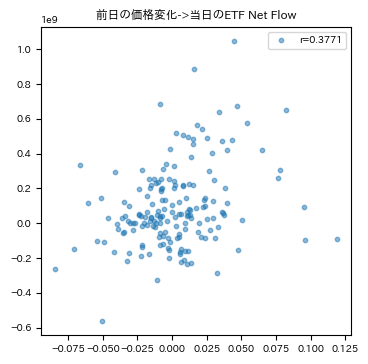

In [52]:
ohlcv_tmp = ohlcv.copy()
ohlcv_tmp['coinbase_ror_s1'] = ohlcv_tmp['coinbase_ror'].shift(1)
plt.title('前日の価格変化->当日のETF Net Flow')
plt.scatter(ohlcv_tmp['coinbase_ror_s1'], ohlcv_tmp['total'], alpha=0.5, s=10, label=f'r={ohlcv_tmp["coinbase_ror"].corr(ohlcv_tmp["total"]):.4f}')
plt.legend();

## 個別銘柄における価格変化とNet Flowの関係

- ビットコインの価格変化が、個別のETFのNet Flowに与える影響を確認してみます。
- まず、当日の価格変化と個別のNet Flow の相関を取ってみます。

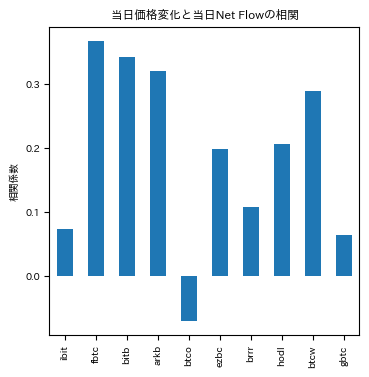

In [53]:
ohlcv_tmp = ohlcv.copy()
corrs = {symbol: ohlcv_tmp['coinbase_ror'].corr(ohlcv_tmp[symbol]) for symbol in ['ibit', 'fbtc', 'bitb', 'arkb', 'btco', 'ezbc', 'brrr', 'hodl', 'btcw', 'gbtc']}
plt.title('当日価格変化と当日Net Flowの相関')
plt.ylabel('相関係数')
pd.Series(corrs).plot(kind='bar');

- 続いて、前日の価格変化と個別のNet Flow の相関を取ってみます。

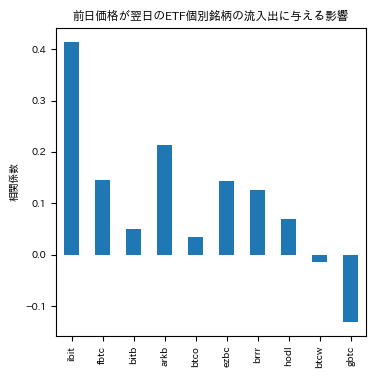

In [54]:
ohlcv_tmp = ohlcv.copy()
ohlcv_tmp['coinbase_ror_s1'] = ohlcv_tmp['coinbase_ror'].shift(1)
corrs = {symbol: ohlcv_tmp['coinbase_ror_s1'].corr(ohlcv_tmp[symbol]) for symbol in ['ibit', 'fbtc', 'bitb', 'arkb', 'btco', 'ezbc', 'brrr', 'hodl', 'btcw', 'gbtc']}
plt.title('前日価格が翌日のETF個別銘柄の流入出に与える影響')
plt.ylabel('相関係数')
pd.Series(corrs).plot(kind='bar');

- IBITやGBTCは特徴がありそうです。
- この各銘柄の特徴（どのようなタイミングで流入が起こるか、流入が起こったときにどのように価格に影響を与えるか）を個別に把握するのが肝な気がします。
- これらの影響は構造的に移り変わる可能性があるので、戦略を作成するなら丁寧に監視する必要がありそうです。

# 単純な戦略を作成


## 戦略1

- 当日のETF Net Flow（ラグゼロ）のプラス・マイナスにより、ロング or ショート。
- これはリークなので、右肩上がりの損益曲線になります。

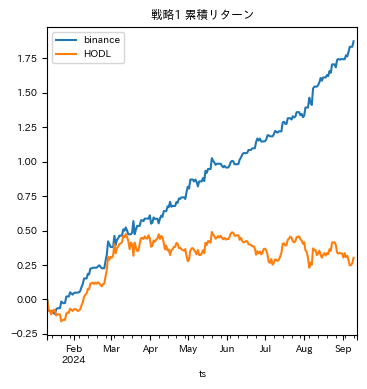

In [55]:
ohlcv_tmp = ohlcv.copy()
ohlcv_tmp['total'] = ohlcv_tmp['total'].fillna(0)
ohlcv_tmp['signal'] = np.sign(ohlcv_tmp['total'])
plt.title('戦略1 累積リターン')
(ohlcv_tmp['signal'] * ohlcv_tmp['binance_usdm_ror']).cumsum().plot(label='binance')
ohlcv_tmp['binance_ror'].cumsum().plot(label='HODL')
plt.legend();

## 戦略2

- 前日のETF Net Flow（ラグ1）のプラス・マイナスにより、ロング or ショート。
- これでも半分リーク（後述）

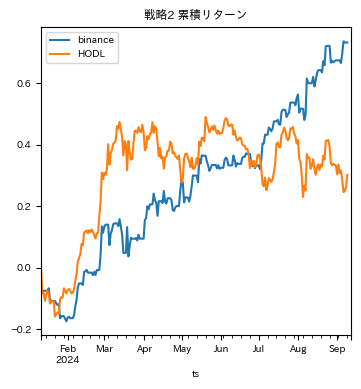

In [56]:
ohlcv_tmp = ohlcv.copy()
ohlcv_tmp['total_s1'] = ohlcv_tmp['total'].fillna(0).shift(1)
ohlcv_tmp['signal'] = np.sign(ohlcv_tmp['total_s1'])
plt.title('戦略2 累積リターン')
(ohlcv_tmp['signal'] * ohlcv_tmp['binance_usdm_ror']).cumsum().plot(label='binance')
ohlcv_tmp['binance_ror'].cumsum().plot(label='HODL')
plt.legend();

- 9:00時点で前日のETF Net Flowが出揃わないため、リークの可能性が高いです。
  - ちなみに本日9:00の時点で前日Net Flowが出そろっていた銘柄は、BITB, ARKB, EZBC, HODL, GBTC
  - IBITは遅かった。12:50ごろ取得可能でした。
  - GBTC、FBTCあたりは比較的早い時間に取得できることが多いかも　→観察中なので、近日中に結果をまとめます。
- 以下のような方法でデータ取得を早められる可能性はあります。
  - 一次ソースを監視（各ファンドのWebサイト、公式発表など）。
- あるいは以下のような方法で推定。
  - 各ETFのプレミアムとディスカウント。
  - Coinbase乖離。
  - オンチェーン情報（各ファンドのアドレス）。
  - ただし、結局ラグ1の情報を更に推定することになるので不確実性が高くなります。

## 戦略3

- 比較的早く出揃うGBTC、ARKB、BITBのラグ1、およびIBITのラグ2を使って、ロング or ショート。
- IBITはラグ2やラグ3でも入れたほうが良くなりそう（これは相関に特徴があったので、調査予定）

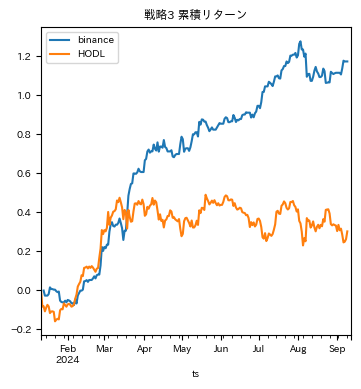

In [57]:
ohlcv_tmp = ohlcv.copy()
ohlcv_tmp['gbtc_s1'] = ohlcv_tmp['gbtc'].fillna(0).shift(1)
ohlcv_tmp['bitb_s1'] = ohlcv_tmp['bitb'].fillna(0).shift(1)
ohlcv_tmp['arkb_s1'] = ohlcv_tmp['arkb'].fillna(0).shift(1)
# ohlcv_tmp['ezbc_s1'] = ohlcv_tmp['ezbc'].fillna(0).shift(1)
# ohlcv_tmp['hodl_s1'] = ohlcv_tmp['hodl'].fillna(0).shift(1)
ohlcv_tmp['ibit_s2'] = ohlcv_tmp['ibit'].fillna(0).shift(2)
ohlcv_tmp['signal'] = np.sign(ohlcv_tmp['gbtc_s1'] + ohlcv_tmp['ibit_s2'] + ohlcv_tmp['bitb_s1'] + ohlcv_tmp['arkb_s1'])
plt.title('戦略3 累積リターン')
(ohlcv_tmp['signal'] * ohlcv_tmp['binance_usdm_ror']).cumsum().plot(label='binance')
ohlcv_tmp['binance_ror'].cumsum().plot(label='HODL')
plt.legend();

## 参考戦略1

- GBTC、IBIT、FBTC、それぞれのNet Flowのプラス・マイナスでロング or ショート
- 個別でやっても使えません。トータルが必要。

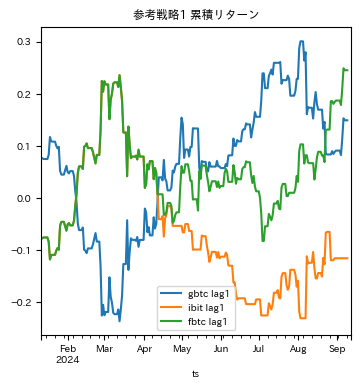

In [58]:
ohlcv_tmp = ohlcv.copy()
plt.title('参考戦略1 累積リターン')
ohlcv_tmp['gbtc_s1'] = ohlcv_tmp['gbtc'].fillna(0).shift(1)
(np.sign(ohlcv_tmp['gbtc_s1']) * ohlcv_tmp['binance_usdm_ror']).cumsum().plot(label='gbtc lag1')
ohlcv_tmp['ibit_s1'] = ohlcv_tmp['ibit'].fillna(0).shift(1)
(np.sign(ohlcv_tmp['ibit_s1']) * ohlcv_tmp['binance_usdm_ror']).cumsum().plot(label='ibit lag1')
ohlcv_tmp['fbtc_s1'] = ohlcv_tmp['fbtc'].fillna(0).shift(1)
(np.sign(ohlcv_tmp['fbtc_s1']) * ohlcv_tmp['binance_usdm_ror']).cumsum().plot(label='fbtc lag1')
plt.legend();

## 参考戦略2

- GBTC、IBIT、FBTC、それぞれのNet Flowについて、直近7日平均よりプラス・マイナスでロング or ショート
- 5月ごろまではGBTCはこの戦略でも利益が出ていたようです。
- 最近はGBTCの流出が減っており、効かなくなっています。

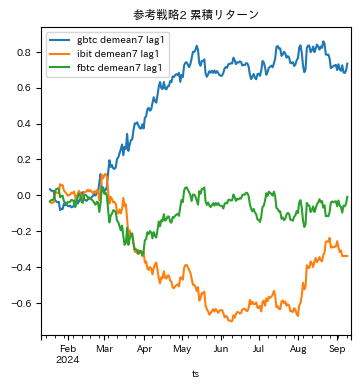

In [59]:
ohlcv_tmp = ohlcv.copy()
plt.title('参考戦略2 累積リターン')
ohlcv_tmp['gbtc'] = ohlcv_tmp['gbtc'].fillna(0)
ohlcv_tmp['ibit'] = ohlcv_tmp['ibit'].fillna(0)
ohlcv_tmp['fbtc'] = ohlcv_tmp['fbtc'].fillna(0)
ohlcv_tmp['gbtc_demean_s1'] = (ohlcv_tmp['gbtc'] - ohlcv_tmp['gbtc'].rolling(7).mean()).shift(1)
ohlcv_tmp['ibit_demean_s1'] = (ohlcv_tmp['ibit'] - ohlcv_tmp['ibit'].rolling(7).mean()).shift(1)
ohlcv_tmp['fbtc_demean_s1'] = (ohlcv_tmp['fbtc'] - ohlcv_tmp['fbtc'].rolling(7).mean()).shift(1)
(np.sign(ohlcv_tmp['gbtc_demean_s1']) * ohlcv_tmp['binance_usdm_ror']).cumsum().plot(label='gbtc demean7 lag1')
(np.sign(ohlcv_tmp['ibit_demean_s1']) * ohlcv_tmp['binance_usdm_ror']).cumsum().plot(label='ibit demean7 lag1')
(np.sign(ohlcv_tmp['fbtc_demean_s1']) * ohlcv_tmp['binance_usdm_ror']).cumsum().plot(label='fbtc demean7 lag1')
plt.legend();

## まとめ

- ETF Net Flowの指標は、トレード戦略として使える可能性があります。
- ETF Net Flowをなるべく早めに・正確に検知や推定を行うことで、有利にトレードを行える可能性があります。

- 面白いのは、ビットコインの上下予測は難しい（特に日足は難しい）が、それに関連のあるETF Net Flowはいくつかの方法で推定できる可能性があるところ。

# ETF Net Flowを推定するには

## 例1）各ETFの価格・プレミアム・ディスカウントの変化から、流入を推定

- 個別のETF銘柄について、当日の価格変化により、その日のNet Flowを推定できるかもしれません。
- FBTCの例。
  - プレミアムやディスカウントを使うと精度がよくなる可能性があります。

In [60]:
import yfinance as yf

fbtc = yf.download('FBTC', start='2024-01-01', interval='1d')
fbtc.index = fbtc.index.tz_localize('UTC')
fbtc['fbtc_ror'] = (fbtc['Close'] - fbtc['Open']) / fbtc['Open']
ohlcv['fbtc_ror'] = fbtc['fbtc_ror']

[*********************100%%**********************]  1 of 1 completed


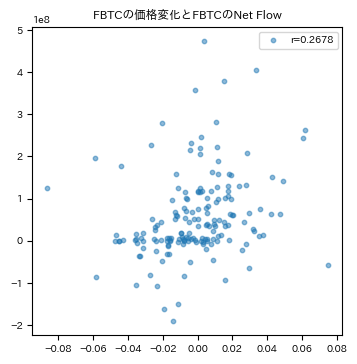

In [61]:
ohlcv_tmp = ohlcv.copy()
plt.title('FBTCの価格変化とFBTCのNet Flow')
plt.scatter(ohlcv_tmp['fbtc_ror'], ohlcv_tmp['fbtc'], alpha=0.5, s=10, label=f'r={ohlcv_tmp["fbtc_ror"].corr(ohlcv_tmp["fbtc"]):.4f}')
plt.legend();

## 例2）コインベース乖離

- ETF Net Flowにより裏付け資産が調整されるのであれば、コインベース乖離に影響が現れる可能性があります（Coinbaseで調達されると仮定）。

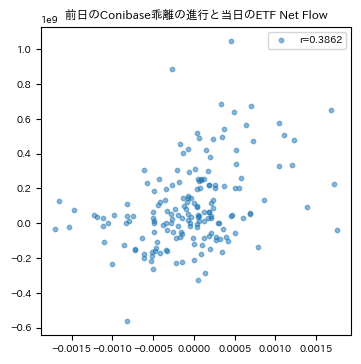

In [62]:
ohlcv_tmp = ohlcv.copy()
ohlcv_tmp['coinbase_binance_dev_s1'] = ohlcv_tmp['coinbase_binance_dev'].shift(1)
plt.title('前日のConibase乖離の進行と当日のETF Net Flow')
plt.scatter(ohlcv_tmp['coinbase_binance_dev_s1'], ohlcv_tmp['total'], alpha=0.5, s=10, label=f'r={ohlcv_tmp["coinbase_binance_dev_s1"].corr(ohlcv_tmp["total"]):.4f}')
plt.legend();

## 例3）マクロ系指標

In [63]:
# S&P500インデックス価格の取得
sp500 = yf.download('^GSPC', start='2024-01-01', interval='1d')
sp500.index = sp500.index.tz_localize('UTC')
sp500['sp_ror'] = (sp500['Close'] - sp500['Open']) / sp500['Open']

[*********************100%%**********************]  1 of 1 completed


In [64]:
ohlcv['sp_ror'] = sp500['sp_ror']

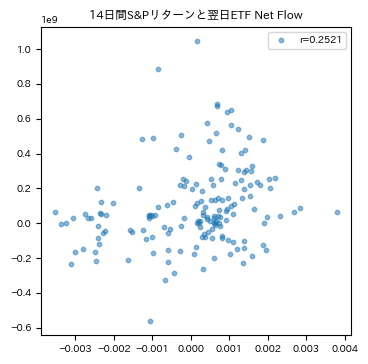

In [65]:
# 14日間のSPリターンと次の日のETF流入量
ohlcv_tmp = ohlcv.copy()
ohlcv_tmp['sp_ror'] = ohlcv_tmp['sp_ror'].fillna(0)
ohlcv_tmp['sp_ror_mean14_s1'] = ohlcv_tmp['sp_ror'].rolling(14).mean().shift(1)
plt.title('14日間S&Pリターンと翌日ETF Net Flow')
plt.scatter(ohlcv_tmp['sp_ror_mean14_s1'], ohlcv_tmp['total'], alpha=0.5, s=10, label=f'r={ohlcv_tmp["sp_ror_mean14_s1"].corr(ohlcv_tmp["total"]):.4f}')
plt.legend();

# 今日の結論

- ビットコインETF経由での資金流入（流出）は、価格に影響を及ぼしている、と言えます。
- ラグ相関を取ったとき、影響の方向は「前日の価格上昇（下落）→当日のETF流入（流出）」です。
- ただし、ETF流入は自己相関もあるため、いったん流入が始まるとその翌日や翌々日にも流入が起こりやすいようです。これが結果として前日ETF流入→当日価格上昇 という影響も形成しているようです。
- 前日のETF流入（流出）を指標とした戦略もワークする可能性があります。ただし有利にトレードを進めるにはひと工夫が必要です。
- ETF流入（流出）は、マクロ指標にも相関があります。このため、マクロ指標→当日ETF流入の予測→当日ビットコイン価格変化の予測 のルートが以前より重要になっている印象を受けます。

- ETFは正のフィードバックを強化する。
- 次の価格上昇を一端を担うのはやはりETFによる流入になりそう（個人的見解）。

# 次回は

- ETFの続きをやるかもやらないかも